In [37]:
import numpy as np
import pandas as pd
from pandas import Series

import pathlib
from glob import glob
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.python.keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, BackupAndRestore
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import regularizers

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!unzip /content/drive/MyDrive/graduation/Land_use_Scene_Bicubic.zip

Streaming output truncated to the last 5000 lines.
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000491.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000485.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000240.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000254.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000283.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000297.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000042.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000056.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000095.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000031.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/intersection_000025.png  
  inflating: Land_use_Scene_Bicubic/train/intersection/int

In [42]:
# Data paths in drive
src_path_train = "/content/Land_use_Scene_Bicubic/train"
src_path_val = "/content/Land_use_Scene_Bicubic/val"
src_path_test = "/content/Land_use_Scene_Bicubic/test"

# Initializing IDG instances for training and testing

train_IDG = ImageDataGenerator(rescale=1./255,
    rotation_range=2,
    zoom_range=0.1,
    horizontal_flip=True)

test_IDG = ImageDataGenerator(rescale= 1./255.0)

In [43]:
batch_size = 32
train_generator = train_IDG.flow_from_directory(
    src_path_train,
    target_size=(150,150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

validation_generator = train_IDG.flow_from_directory(
    src_path_val, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

test_generator = test_IDG.flow_from_directory(
    src_path_test,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed = 42)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [44]:
model = tf.keras.applications.mobilenet.MobileNet(
    include_top = False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256, 3),
    pooling="max",
    classes=21,
    classifier_activation="softmax")

model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

In [45]:
from keras import Sequential



model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(model)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
# model_2.add(Dense(1024,activation=('relu')))
model_2.add(Dense(1024,activation=('relu')))
model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(512,activation=('relu'))) 
model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(256,activation=('relu'))) 

# 
# model_2.add(Dense(2048,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01))) 
# model_2.add(Dropout(.3, seed=42))#Adding a dropout layer that will randomly drop 50% of the weights
# model_2.add(Dense(1024,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01)))
# model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(21,activation=('softmax'))) #This is the classification layer

# for layer in model.layers:
model_2.layers[0].trainable = False

In [46]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [47]:
from keras.optimizers import SGD,Adam
# from tensorflow.keras.optimizers.legacy import SGD
learn_rate=.001

sgd = tf.keras.optimizers.legacy.SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.1, min_lr=0.00001,min_delta=0.001)
# early_stopping_monitor = EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)

In [49]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:
history = model_2.fit_generator(
              train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // batch_size,
              callbacks=[learning_rate_reduction],
              epochs = 10)

<ipython-input-50-6d2c0cba9fef>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(


Epoch 1/10
229/229 [==============================] - 73s 313ms/step - loss: 1.1980 - accuracy: 0.6372 - val_loss: 0.5866 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 2/10
229/229 [==============================] - 64s 281ms/step - loss: 0.5805 - accuracy: 0.8135 - val_loss: 0.5049 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 3/10
229/229 [==============================] - 54s 235ms/step - loss: 0.4324 - accuracy: 0.8567 - val_loss: 0.3891 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 4/10
229/229 [==============================] - 53s 233ms/step - loss: 0.3836 - accuracy: 0.8752 - val_loss: 0.3875 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 5/10
229/229 [==============================] - 53s 233ms/step - loss: 0.3311 - accuracy: 0.8885 - val_loss: 0.3720 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 6/10
229/229 [==============================] - 62s 272ms/step - loss: 0.3267 - accuracy: 0.8944 - val_loss: 0.3979 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 7/10
229/229 [==============================] 

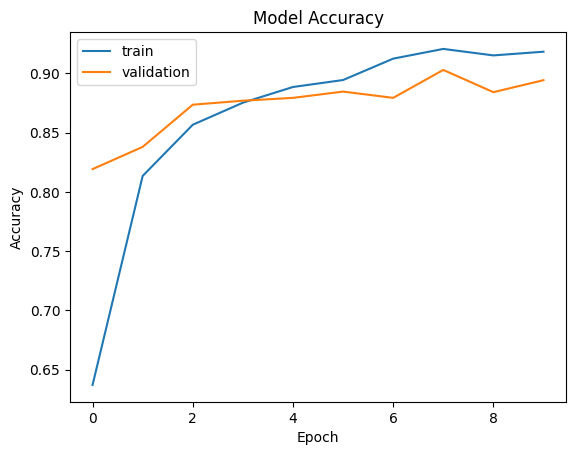

In [51]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

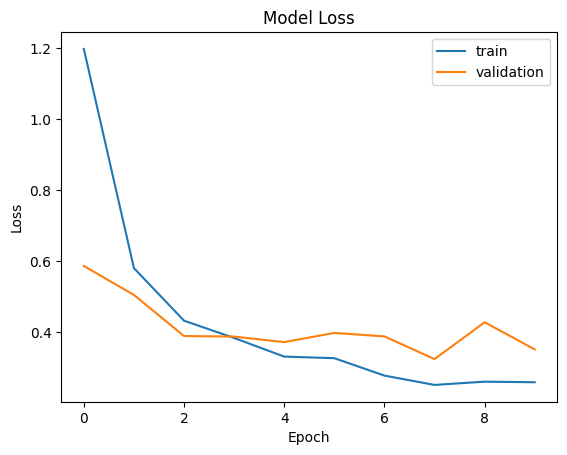

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [53]:
evaluate = model_2.evaluate(test_generator)
print(evaluate)

1050/1050 [==============================] - 6s 6ms/step - loss: 0.3640 - accuracy: 0.8867
[0.36404457688331604, 0.8866666555404663]


In [54]:
print('The testing accuracy is :',evaluate[1]*100, '%')

The testing accuracy is : 88.66666555404663 %


In [55]:
model_2.save("mobilenet_landuse_Bicubic.h5")

In [56]:
from google.colab import files
files.download('/content/mobilenet_landuse_Bicubic.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>